In [1]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import rasterio
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point, box
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil

# NOTE: change to your own path when setting workspace
# ws = r'C:\Users\emers\.rainfall'
ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


### Step 1: Get Data
Download vector data for the state geometry and the geometry of buildings within it, and store these datasets in geodataframes. The vector data can be downloaded for any US State that you have a precipitation cdf for--just manipulate the `state` variable in the following code cell.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Unzip files in python (geeks for geeks)](https://www.geeksforgeeks.org/unzipping-files-in-python/)

In [2]:
# set target state
state = 'arizona'

# get state bounds
state_gdf = gpd.read_file(
    f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson', crs='epsg:4326'
)

In [3]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        print('zip downloaded')

        with ZipFile(filepath, 'r') as z:
            z.extractall(
                path=ws
                )

print(f'file unzipped successfully ({os.path.getsize(filepath.strip(".zip")) / 1000000} MB)')

zip downloaded
file unzipped successfully (845.767832 MB)


In [4]:
# read buildings into geojson
buildings_gdf = gpd.read_file(filepath.strip('.zip'), crs='epsg:4326')
buildings_gdf.to_crs('epsg:32612')
print('read into dataframe successfully')

read into dataframe successfully


### Step 2: Prep the NC file
Remove some dimensions and summarize across the `time` attribute into
- `max` precip in the timespan
- `min` precip in the timespan
- `mean` precip among the timespan

##### References:
- [dropping the `expver` variable](https://code.mpimet.mpg.de/boards/1/topics/8961)

In [5]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))


                          tp
longitude latitude          
-108.0    32.00     0.000645
          31.75     0.000628
          31.50     0.000587
          31.25     0.000650
          31.00     0.000684
                          tp
longitude latitude          
-108.0    32.00     0.003283
          31.75     0.003353
          31.50     0.003656
          31.25     0.004519
          31.00     0.004999
                     tp
longitude latitude     
-108.0    32.00     0.0
          31.75     0.0
          31.50     0.0
          31.25     0.0
          31.00     0.0


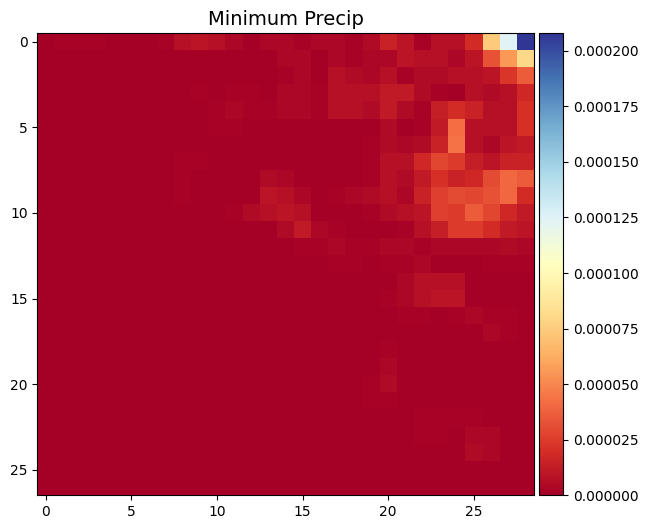

In [6]:
# Plot Minimums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(min.to_array()[0], cmap='RdYlBu')
ax.set_title("Minimum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

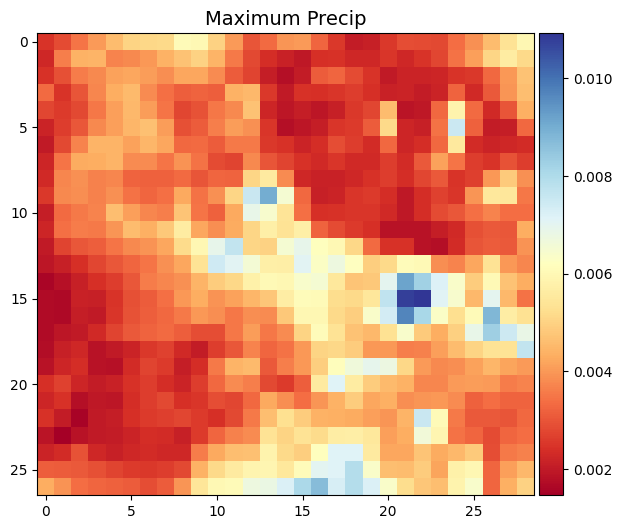

In [7]:
# Plot Maximums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(max.to_array()[0], cmap='RdYlBu')
ax.set_title("Maximum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

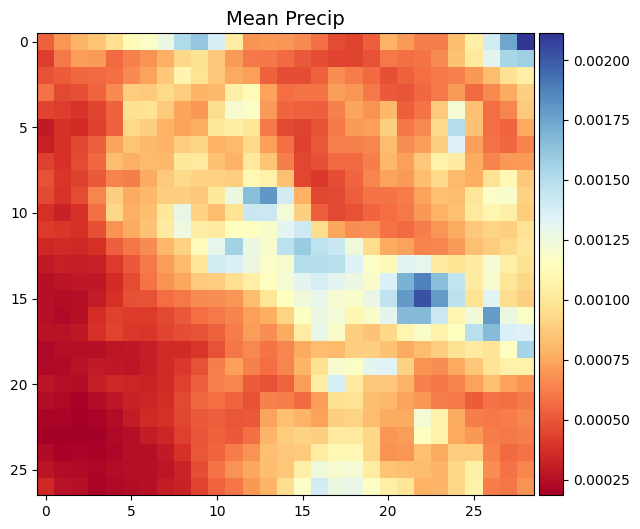

In [8]:
# Plot Means
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean.to_array()[0], cmap='RdYlBu')
ax.set_title("Mean Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

### Step 3: Reproject and Read into Rasterio
As you can see from the axes of the above plots, the cdf file is still in degrees that count up from its corners, so it appears unaware of its location. Creating a spatially-aware raster is necessary before analysis can be perfomed between buildings and precip

In [9]:
# Converts the NC file with precipitation data to A Raster
precip = no_expver['tp']
precip = precip.rio.set_spatial_dims(x_dim='latitude', y_dim='longitude')
reordered = precip.transpose('time', 'latitude', 'longitude')
reordered.rio.write_crs('EPSG:4326', inplace=True)
reordered.rio.to_raster(os.path.join(ws, 'precip_raster.tiff'))

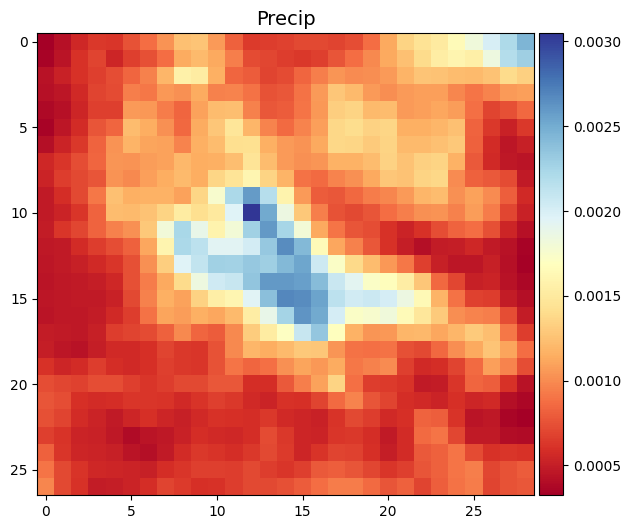

In [10]:
# Opens raster created in last cell
precip_raster = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))  

# Reads the raster with the band representing the month, 1 being Jan. 2013
precip_array = precip_raster.read(1)

fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(precip_array, cmap='RdYlBu')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [11]:
# clip buildings (for speedy development)
test = gpd.read_file(
    os.path.join(ws, 'test.geojson'),
    crs='epsg:4326'
    ).to_crs(
    'epsg:32612'
    )

subset = gpd.clip(buildings_gdf.to_crs('epsg:32612'), test)

c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [12]:
# set bldg = buildings_gdf for complete analysis
bldg = subset
# bldg = buildings_gdf
precip = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))

# add necesasry fields to building data
bldg['area_m2'] = bldg['geometry'].area

bldg = bldg.to_crs('epsg:4326') # necessary due to GDAL driver drama. Area is still accurate bc derived from UTM

bldg['centroid'] = bldg['geometry'].centroid


C:\Users\sgartrel\AppData\Local\Temp\ipykernel_29312\670550665.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bldg['centroid'] = bldg['geometry'].centroid


epsg:4326 GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


<AxesSubplot: >

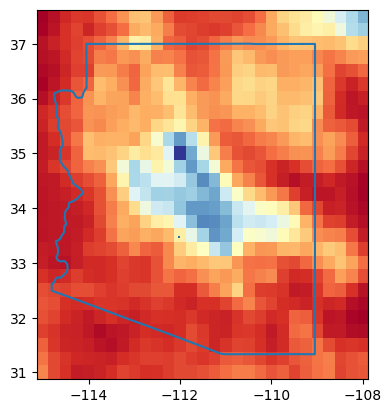

In [13]:
# this step takes about an hour for the full building dataset

from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[precip.bounds[0], precip.bounds[2], precip.bounds[1], precip.bounds[3]]
ax = rasterio.plot.show(precip, extent=extent, ax=ax, cmap='RdYlBu')
state_precip = state_gdf.boundary.plot(ax=ax)
print(bldg.crs, precip.crs)


coord_list = [(x,y) for x,y in zip(bldg['centroid'].x , bldg['centroid'].y)]
bldg['precip_m'] = [x for x in precip.sample(coord_list)]
bldg.plot(ax=state_precip)

### Step 4: Do Some Actual Analysis
Now that the raster is georeferenced and its values have been successfully ported to the geodataframe, we can begin summarizing and drawing conclusions about the state's rainwater harvesting potential. Some facts to note:
- AZ'  driest month: June
- AZ's wettest month: March
- AZ's monsoon season: June-September
- Rainfall is measured in meters for this dataset
    - the base area of any rain gauge is linearly related to how much rain it catches, meaning that precip data in meters can be simultaneously interpreted as mm per square meter/foot/mile/etc. 

The process:
- First, we filter out buildings that are too big to count as residential houses, a subjective threshold we've defined as 5000 square feet (464.5 square meters)
- Then, we summarize precipitation data spanning the 10 year period for each building, in terms of harvest amounts (m3)

#### References:
- [Arizona Weather](https://www.rssweather.com/climate/Arizona/Phoenix/#:~:text=The%20driest%20month%20in%20Phoenix,March%20is%20the%20wettest%20month.)

In [14]:
# define parameters (area threshold in meters, daily residential usage in gallons)
residential_roof = 464.5
residential_usage = 146

# drop non-residential sized buildings and get water usage in cubic meters/month (converted from gallons per day)
bldg = bldg[bldg['area_m2'] <= residential_roof]
bldg['usage_m3'] = (residential_usage * 30 * 3.78541) / 1000

# summarize the precip array
bldg['mean_precip_m'] = bldg['precip_m'].apply(lambda x: np.mean(x))
bldg['min_precip_m'] = bldg['precip_m'].apply(lambda x: np.min(x))
bldg['max_precip_m'] = bldg['precip_m'].apply(lambda x: np.max(x))

# get harvest values in cubic meters
bldg['mean_harvest_m3'] = bldg['mean_precip_m'] * bldg['area_m2']
bldg['min_harvest_m3'] = bldg['min_precip_m'] * bldg['area_m2']
bldg['max_harvest_m3'] = bldg['max_precip_m'] * bldg['area_m2']

# average the 3rd month of every year in 120 months
bldg['mar_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(3, (len(x)-1), 12)
    ]
))

# average the 6th month of every year in 120 months
bldg['jun_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(6, (len(x)-1), 12)
    ]
))

# average monsoon season (6th - 9th month every year)


bldg

c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,release,capture_dates_range,geometry,area_m2,centroid,precip_m,usage_m3,mean_precip_m,min_precip_m,max_precip_m,mean_harvest_m3,min_harvest_m3,max_harvest_m3,mar_precip,jun_precip
1936737,2,5/7/2020-5/21/2020,"POLYGON ((-112.02687 33.46594, -112.02675 33.4...",36.477577,POINT (-112.02681 33.46593),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.026442,0.0,0.140436,0.00012,0.001103
2160735,2,5/7/2020-5/21/2020,"POLYGON ((-112.02786 33.46590, -112.02786 33.4...",155.828346,POINT (-112.02773 33.46593),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.112956,0.0,0.599928,0.00012,0.001103
2540125,2,5/7/2020-5/21/2020,"POLYGON ((-112.02539 33.46591, -112.02538 33.4...",152.401918,POINT (-112.02532 33.46596),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.110472,0.0,0.586737,0.00012,0.001103
1338371,2,5/7/2020-5/21/2020,"POLYGON ((-112.02514 33.46593, -112.02513 33.4...",285.812657,POINT (-112.02504 33.46601),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.207178,0.0,1.100359,0.00012,0.001103
1733217,2,5/7/2020-5/21/2020,"POLYGON ((-112.02658 33.46613, -112.02646 33.4...",279.856872,POINT (-112.02652 33.46602),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.202861,0.0,1.077429,0.00012,0.001103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527431,2,5/7/2020-5/21/2020,"POLYGON ((-112.01567 33.48011, -112.01583 33.4...",180.637047,POINT (-112.01575 33.48016),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.130939,0.0,0.695440,0.00012,0.001103
2646753,2,5/7/2020-5/21/2020,"POLYGON ((-112.01536 33.48010, -112.01531 33.4...",46.573352,POINT (-112.01534 33.48006),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.033760,0.0,0.179304,0.00012,0.001103
849219,2,5/7/2020-5/21/2020,"POLYGON ((-112.01475 33.48003, -112.01484 33.4...",190.599726,POINT (-112.01480 33.48014),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.138161,0.0,0.733796,0.00012,0.001103
342200,2,5/7/2020-5/21/2020,"POLYGON ((-112.01400 33.48007, -112.01400 33.4...",324.307794,POINT (-112.01391 33.48016),"[0.0015316708, 0.00049972255, 0.000722914, 4.7...",16.580096,0.000725,0.0,0.00385,0.235082,0.0,1.248562,0.00012,0.001103


In [15]:
# now, compute deficit between water used and harvested per month

# deficit under average conditions (mean precip)
bldg['mean_deficit_m3'] = bldg['usage_m3'] - bldg['mean_harvest_m3']

# deficit under optimal conditions (max precip)
bldg['wet_deficit_m3'] = bldg['usage_m3'] - bldg['max_harvest_m3']

# deficit under most arid conditions (min precip)
bldg['arid_deficit_m3'] = bldg['usage_m3'] - bldg['min_harvest_m3']

c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\sgartrel\Anaconda3\envs\Rainfall\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [16]:
# map is incredibly underwhelming for 10 minutes of load time
# base = state_gdf.boundary.plot(edgecolor='black')
# bldg.plot(ax=base, column='mean_deficit_m3', cmap='Blues')

<AxesSubplot: >

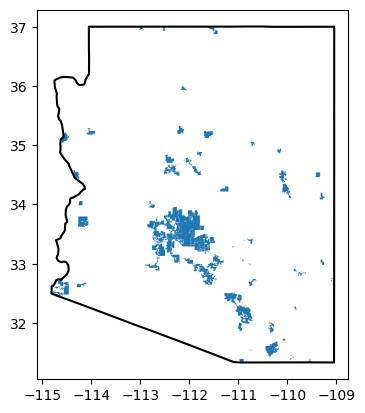

In [17]:
# get Arizona cities to break down data
cities = gpd.read_file(os.path.join(ws, 'az_cities.geojson')).set_crs('epsg:3785')
cities = cities.to_crs('epsg:4326')
city_lyr = cities.plot()
state_gdf.boundary.plot(ax=city_lyr, edgecolor='black')

In [23]:
# join city data to buildings
bldgs_by_city = bldg.sjoin(cities)
phnx = bldgs_by_city[bldgs_by_city['NAME'] == 'PHOENIX']
flag = bldgs_by_city[bldgs_by_city['NAME'] == 'FLAGSTAFF']
pres = bldgs_by_city[bldgs_by_city['NAME'] == 'PRESCOTT']
tucs = bldgs_by_city[bldgs_by_city['NAME'] == 'TUCSON']



PHOENIX:
mean annual precip (m):                 0.000724872516002506
deficit under average conditions (m^3): 16.455682852885392
deficit under wettest conditions (m^3): 15.919316028187174
deficit under driest conditions (m^3):  16.5800958


AttributeError: 'AxesSubplot' object has no attribute 'show'

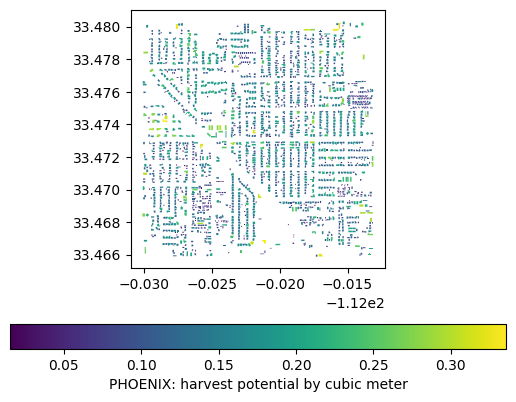

In [30]:
print("\n\nPHOENIX:")
print(f'mean annual precip (m):                 {phnx["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {phnx["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {phnx["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {phnx["arid_deficit_m3"].mean()}')
fig, ax = plt.subplots(1, 1)

phnx_plt = phnx.plot(column='mean_harvest_m3',
           ax=ax,
           legend=True,
           legend_kwds={'label': "PHOENIX: harvest potential by cubic meter",
                        'orientation': "horizontal"})

print("\n\nFLAGSTAFF:")
print(f'mean annual precip (m):                 {flag["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {flag["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {flag["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {flag["arid_deficit_m3"].mean()}')
fig, ax = plt.subplots(1, 1)

flag_plt = flag.plot(column='mean_harvest_m3',
           ax=ax,
           legend=True,
           legend_kwds={'label': "FLAGSTAFF: harvest potential by cubic meter",
                        'orientation': "horizontal"})

print("\n\nPRESCOTT:")
print(f'mean annual precip (m):                 {pres["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {pres["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {pres["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {pres["arid_deficit_m3"].mean()}')
fig, ax = plt.subplots(1, 1)

pres_plt = pres.plot(column='mean_harvest_m3',
           ax=ax,
           legend=True,
           legend_kwds={'label': "PRESCOTT: harvest potential by cubic meter",
                        'orientation': "horizontal"})

print("\n\nTUCSON:")
print(f'mean annual precip (m):                 {tucs["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {tucs["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {tucs["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {tucs["arid_deficit_m3"].mean()}')
fig, ax = plt.subplots(1, 1)

tucs_plt = tucs.plot(column='mean_harvest_m3',
           ax=ax,
           legend=True,
           legend_kwds={'label': "TUCSON: harvest potential by cubic meter",
                        'orientation': "horizontal"})

plt.show()